In [13]:
import pandas as pd
from statsmodels.tsa.api import VAR, ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load and format data
df = pd.read_excel(r"C:\Users\Aryan Pandey\Desktop\FRED-Inflation and GDP .xlsx", sheet_name="Monthly")
df = df[['Quarter', 'GDP', 'YOY','raw gdp', 'PCE' ]].dropna()
df = df.set_index('Quarter')

# Optional: convert index to datetime (if using quarters as timestamps)
# df.index = pd.PeriodIndex(df.index, freq='Q')

df['d_YOY'] = df['YOY'].diff()
df = df.dropna()  # Drop rows with NaN values (especially after diff)

# Check stationarity
for col in ['GDP', 'd_YOY']:
    stat, p, *_ = adfuller(df[col])
    print(f"{col} ADF Stat: {stat:.2f}, p-value: {p:.4f}")


GDP ADF Stat: -2.86, p-value: 0.0501
d_YOY ADF Stat: -5.62, p-value: 0.0000


In [14]:
# ARIMA for GDP growth (already stationary, so d=0)
arima_gdp = ARIMA(df['GDP'], order=(1, 0, 1)).fit()
print("ARIMA - GDP Growth:\n", arima_gdp.summary())

# ARIMA for d_YOY (already stationary, so d=0)
arima_yoy = ARIMA(df['d_YOY'], order=(1, 0, 1)).fit()
print("ARIMA - d_YOY (Inflation):\n", arima_yoy.summary())


C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer 

ARIMA - GDP Growth:
                                SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  176
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -316.740
Date:                Mon, 23 Jun 2025   AIC                            641.480
Time:                        12:21:12   BIC                            654.162
Sample:                             0   HQIC                           646.624
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7057      0.460      5.888      0.000       1.805       3.606
ar.L1          0.7106      0.082      8.697      0.000       0.550       0.871
ma.L1          0.0464      0.08

In [15]:
# Use only stationary columns for VAR
df_var = df[['GDP', 'd_YOY']]

# Create VAR model
var_model = VAR(df_var)

# Select lag order using AIC
lag_selection = var_model.select_order(maxlags=4)
print("\nVAR Lag Order Selection:")
print(lag_selection.summary())

# Fit model with selected lag (AIC)
fitted_var = var_model.fit(lag_selection.aic)
print("\nVAR Model Summary:")
print(fitted_var.summary())



VAR Lag Order Selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.2101      0.2467       1.234      0.2250
1     -0.7252    -0.6154*      0.4842     -0.6807
2     -0.6881     -0.5051      0.5026     -0.6138
3     -0.6887     -0.4325      0.5023     -0.5847
4    -0.9265*     -0.5971     0.3960*    -0.7928*
-------------------------------------------------

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     12:21:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.597100
Nobs:                     172.000    HQIC:                 -0.792848
Log likelihood:          -390.437    FPE:                   0.396017
AIC:                    -0.926489    Det(Omega_mle): 

C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


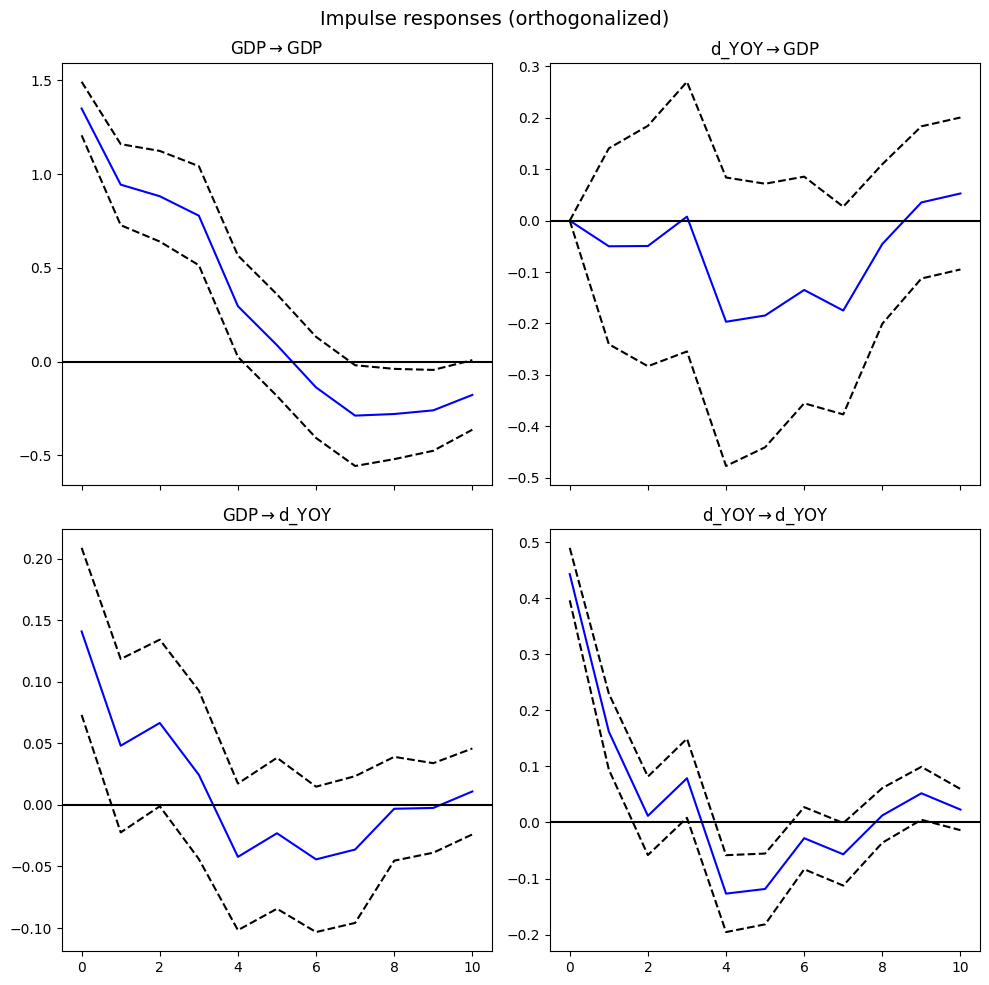

In [16]:
irf = fitted_var.irf(10)
irf.plot(orth=True)
plt.tight_layout()
plt.show()


In [17]:
#Granger causality tests
print(fitted_var.test_causality('GDP', ['d_YOY'], kind='f'))
print(fitted_var.test_causality('d_YOY', ['GDP'], kind='f'))


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: d_YOY does not Granger-cause GDP: fail to reject at 5% significance level. Test statistic: 1.308, critical value: 2.399>, p-value: 0.267>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: GDP does not Granger-cause d_YOY: fail to reject at 5% significance level. Test statistic: 0.904, critical value: 2.399>, p-value: 0.462>


In [18]:
forecast = fitted_var.forecast(y=df_var.values[-4:], steps=8)  # Next 8 quarters
forecast_df = pd.DataFrame(forecast, columns=['gdp_growth_forecast', 'd_YOY_forecast'])
print(forecast_df)


   gdp_growth_forecast  d_YOY_forecast
0             2.156638       -0.057697
1             2.382167        0.092057
2             2.352818       -0.051239
3             2.560949       -0.072552
4             2.738435       -0.007213
5             2.749712       -0.062027
6             2.862393       -0.034654
7             2.905909       -0.002591


In [19]:
normality = fitted_var.test_normality()
print(normality.summary())



normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         3385.          9.488   0.000  4
----------------------------------------


In [20]:
whiteness = fitted_var.test_whiteness(nlags=12)
print(whiteness.summary())


Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         83.20          46.19   0.000 32
----------------------------------------
